## INSTALL ALL

In [ ]:
# Se instala la primera vez
!nvidia-smi
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
%pip install segment-geospatial  
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/bin/bash: {sys.executable}: command not found


## LIBRARIES

In [ ]:
import os
import torch
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import supervision as sv
import psutil
import humanize
import os
import GPUtil as GPU
from samgeo import SamGeo, tms_to_geotiff
from PIL import Image

##CREATE DIRECTORY

In [ ]:
HOME = os.getcwd()
print("HOME:", HOME)
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME} 

## Install Segment Anything Model (SAM)

In [ ]:
CHECKPOINT_PATH = os.path.join(HOME ,  "sam_vit_h_4b8939.pth")
CHECKPOINT_PATH

## Load Model

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

`SamAutomaticMaskGenerator` class

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
IMAGE_NAME = "01.jpg"
IMAGE_PATH = os.path.join(HOME, "", IMAGE_NAME)

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


In [14]:
sam_result = mask_generator.generate(image_rgb)

### Results visualisation with Supervision



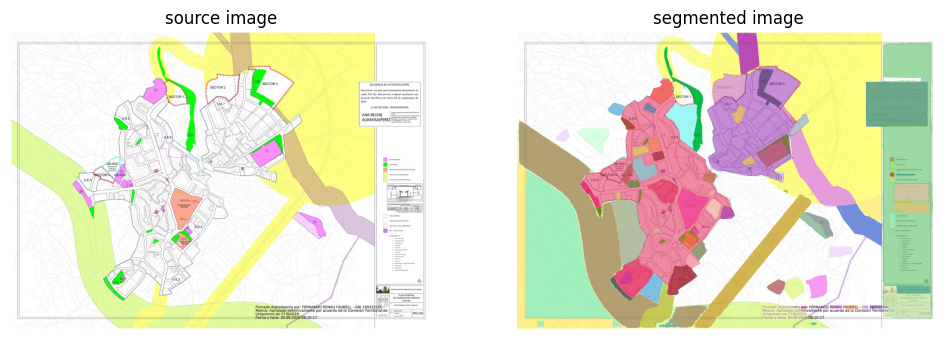

In [15]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)
 
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
) 
 

# EXPORT RESULTS

EXPORT TO TIF

In [16]:
data = Image.fromarray(annotated_image)
data.save( 'C.tif')

In [ ]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = SamGeo(
    checkpoint=checkpoint,
    model_type='vit_h',
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

EXPORT TO IMAGE AND GENERATE SAM

In [ ]:
path_image = "C.tif"
#read_image = PIL.Image.open(path_image)
#image_decode= np.asarray(read_image).astype('float32')
#to_img = array_to_img(image_decode)


In [ ]:
mask = 'resultado_casco.tif'
sam.generate(path_image, mask)

#### EXPORT TO GeoPackage 

In [62]:
vector = 'result.gpkg'
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)